In [4]:
%reload_ext autoreload
%autoreload 2
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.signal as sig
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Dropout
from keras.models import Model, Sequential, load_model

from util import util
from util.logUtil import LOG

Using TensorFlow backend.


In [5]:
# variables
macDir = '/Users/etto/Desktop/tpDatasets/'
winDir = 'E:/SAA_DATA/predictiveMaintenance/'
osDir = winDir
data_folder = '../../storedData/'

train_bearings = np.concatenate([['Bearing1_{:d}'.format(i) for i in range(1,3)],
                           ['Bearing2_{:d}'.format(i) for i in range(1,3)],
                           ['Bearing3_{:d}'.format(i) for i in range(1,3)]])
                           
test_bearings = np.concatenate([['Bearing1_{:d}'.format(i) for i in range(3,8)],
                                ['Bearing2_{:d}'.format(i) for i in range(3,8)],
                                ['Bearing3_{:d}'.format(i) for i in range(3,4)]])

train_files = ['{:s}{:s}.hd5'.format(data_folder, bearing_name) for bearing_name in train_bearings]
test_files = ['{:s}{:s}.hd5'.format(data_folder, bearing_name) for bearing_name in test_bearings]

# keys to use
keyHSpec = 'horSpec'
keyVSpec = 'vertSpec'


In [6]:
testspecs = [
    ['1_3', 5730],
    ['1_4', 339],
    ['1_5', 1610],
    ['1_6', 1460],
    ['1_7', 7570],
    ['2_3', 7530],
    ['2_4', 1390],
    ['2_5', 3090],
    ['2_6', 1290],
    ['2_7', 580],
    ['3_3', 820]
]

In [19]:
# utility functions
def getDataFrame(bearingPath, key):
    return pd.read_hdf(path_or_buf=bearingPath, key=key)

def plotTrainResults(X, Y, rulModel, history):
    plt.plot(history.history['loss'])
    plt.show()

    plt.figure()
    predictions = rulModel.predict(X)
    plt.plot(predictions)
    plt.plot(Y)
    plt.show()

def getModelName(layersizes, epochs, kenmerk):
    modelname = 'models/rulModel_' + kenmerk + '_'
    for size in layersizes:
        modelname += '{:d}_'.format(size)
    modelname += '1_ep{:d}.h5'.format(epochs)
    return modelname

def evaluate_spectro(modelnames, spectro, RUL_value, plotname=''):
    # True Y values
    nr_samples = len(spectro)
    Y_values = np.array([10 * (nr_samples - i) + RUL_value for i in range(1, nr_samples + 1)])

    models = [load_model(mname) for mname in modelnames]  # type: Model
    predictions = [(model.predict(spectro), np.sqrt(model.evaluate(spectro, Y_values))) for model in models]

    x_ax_values = [10 * i for i in range(nr_samples)]

    nr = 0
    for (prediction, rms) in predictions:
        fig = plt.figure(figsize=(10, 6))
        plt.plot(x_ax_values, prediction,label='Predicted RUL')

        plt.plot(x_ax_values, Y_values,label='Actual RUL')
        plt.title(modelnames[nr] + ' - RMS: {:.0f}'.format(rms))
        plt.ylabel('RUL (s)')
        plt.xlabel('Running Time (s)')
        plt.legend()

        if len(plotname) > 0:
            plt.savefig('plots/' + plotname, bbox_inches='tight', dpi=300)  # 600
        else:
            plt.show()

        nr += 1

## bepaal X en Y

In [8]:
spectros_train_hor = [getDataFrame(bearingPath, keyHSpec).values for bearingPath in train_files]
spectros_train_vert = [getDataFrame(bearingPath, keyVSpec).values for bearingPath in train_files]

spectros_test_hor = [getDataFrame(bearingPath, keyHSpec).values for bearingPath in test_files]
spectros_test_vert = [getDataFrame(bearingPath, keyVSpec).values for bearingPath in test_files]

X_train = np.concatenate((np.concatenate(spectros_train_hor, axis=0),
                          np.concatenate(spectros_train_vert, axis=0)), 
                          axis=1)
print(np.shape(X_train))

Y_train = []
for spectro in spectros_train_hor:
    nr_samples = len(spectro)
    Y_train_nw = np.array([10 * (nr_samples - i) for i in range(1, nr_samples +1)])
    Y_train = np.append(Y_train, Y_train_nw)
    
print(np.shape(Y_train))

(7534, 2562)
(7534,)


In [9]:
# dropout 0.2 op alle plaatsen
def trainModel_01(X, Y, layersizes, epochs, kenmerk):
    input_dim = np.shape(X)[1]

    rulModel = Sequential()
    rulModel.add(Dropout(0.2, input_shape=(input_dim,)))
    rulModel.add(Dense(layersizes[0], input_dim=input_dim, activation='relu', name='layer1'))
    rulModel.add(Dropout(0.2))
    for i in range(1, len(layersizes)):
        rulModel.add(Dense(layersizes[i], activation='relu', name='layer{:d}'.format(i + 1)))
        rulModel.add(Dropout(0.2))
    rulModel.add(Dense(1, activation='linear', name='output_layer'))
    rulModel.compile(loss='mean_squared_error', optimizer='adam')
    history = rulModel.fit(X, Y, epochs=epochs, shuffle=True, verbose=1)
    rulModel.save(getModelName(layersizes, epochs, kenmerk))

    plotTrainResults(X, Y, rulModel, history)

    return rulModel, history

In [ ]:
%%capture outTrain
layersizes = [500,200,50]
expName = 'exp20180614'
model, history = trainModel_01(X_train, Y_train, layersizes, 100, expName)

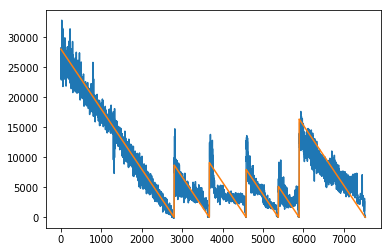

[]

In [27]:
layersizes = [500,200,50]
expName = 'exp20180614'
mname = getModelName(epochs=100, kenmerk=expName, layersizes=layersizes)
model = load_model(mname)
predictions = model.predict(X_train)
plt.plot(predictions)
plt.plot(Y_train)
plt.show()

### Test modellen

##################
# Test: 1_3
##################
1802/1802 [==============================] - 0s 260us/step


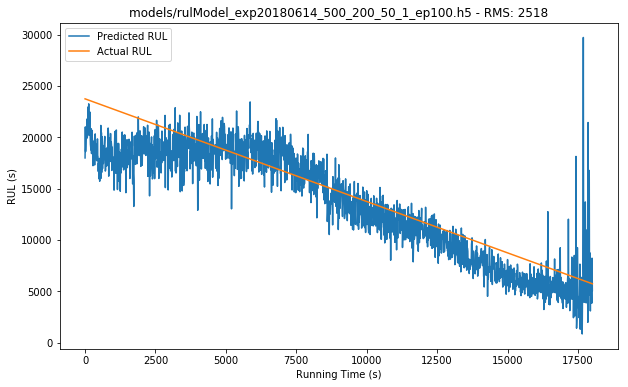

##################
# Test: 1_4
##################
1139/1139 [==============================] - 0s 398us/step


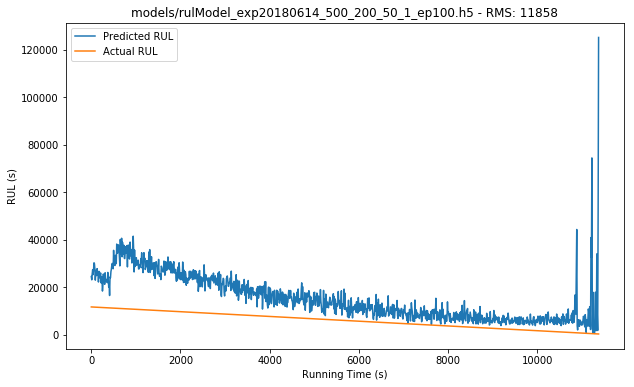

##################
# Test: 1_5
##################
2302/2302 [==============================] - 1s 248us/step


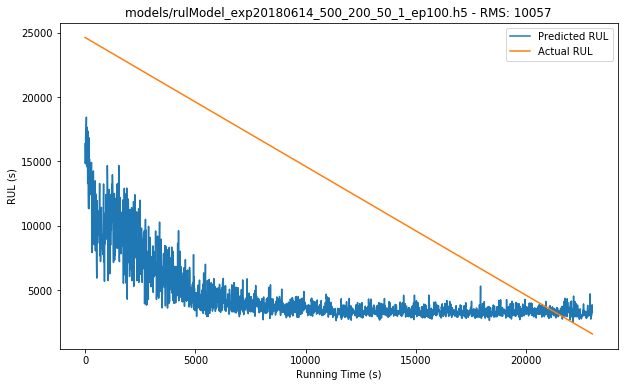

##################
# Test: 1_6
##################
2302/2302 [==============================] - 0s 204us/step


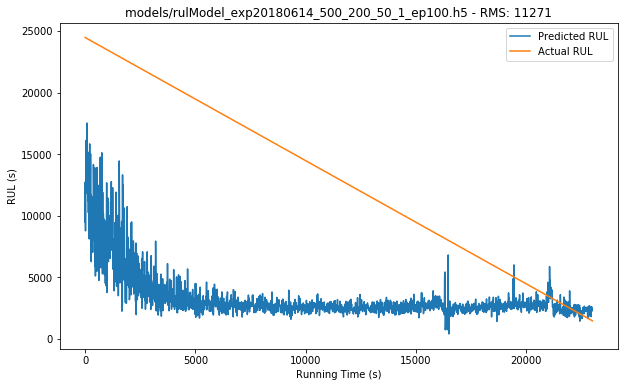

##################
# Test: 1_7
##################
1502/1502 [==============================] - 0s 312us/step


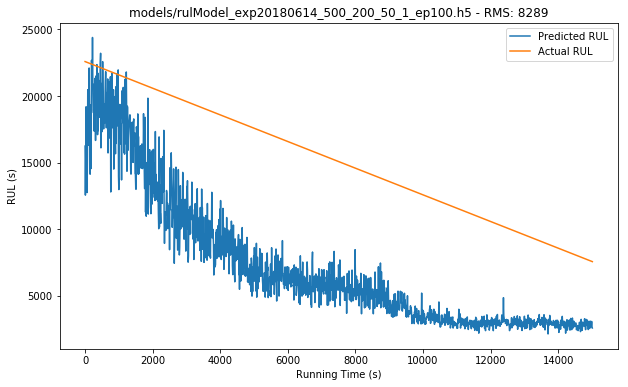

##################
# Test: 2_3
##################
1202/1202 [==============================] - 1s 442us/step


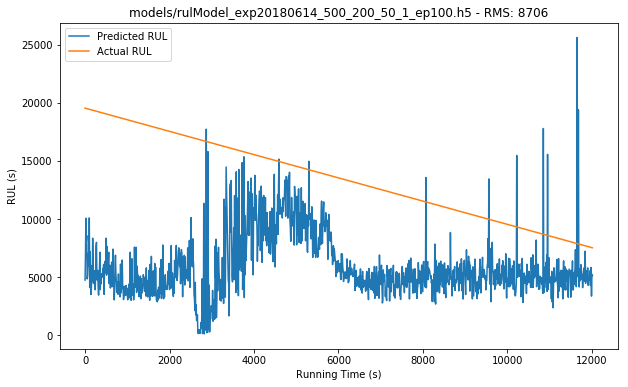

##################
# Test: 2_4
##################
612/612 [==============================] - 0s 791us/step


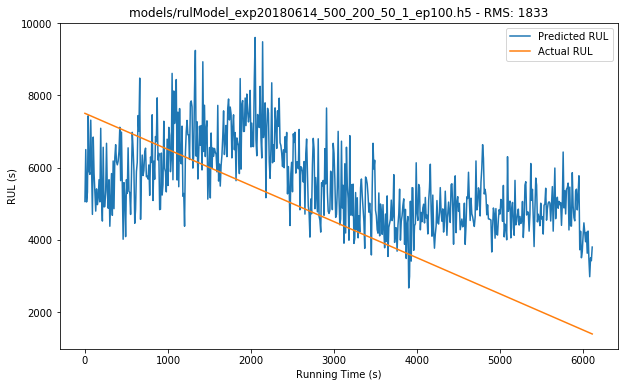

##################
# Test: 2_5
##################
2002/2002 [==============================] - 1s 383us/step


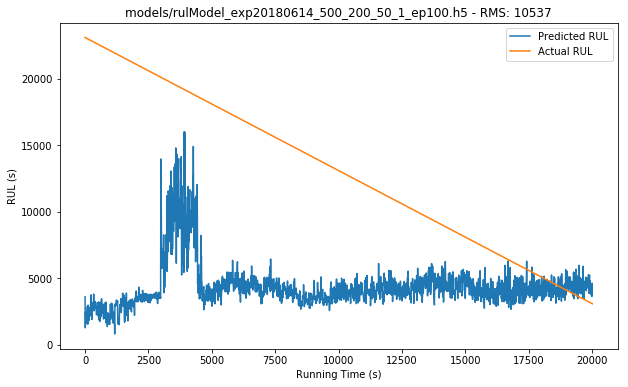

##################
# Test: 2_6
##################
572/572 [==============================] - 0s 851us/step


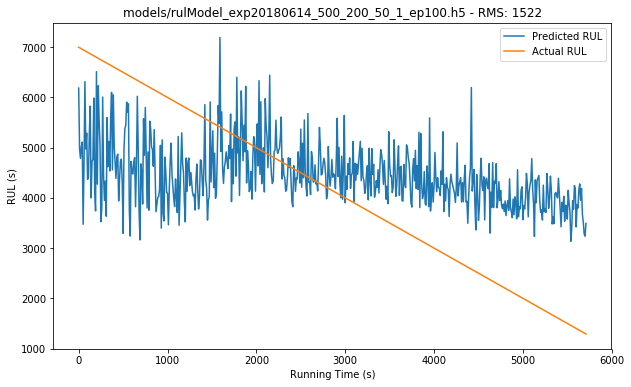

##################
# Test: 2_7
##################
172/172 [==============================] - 1s 3ms/step


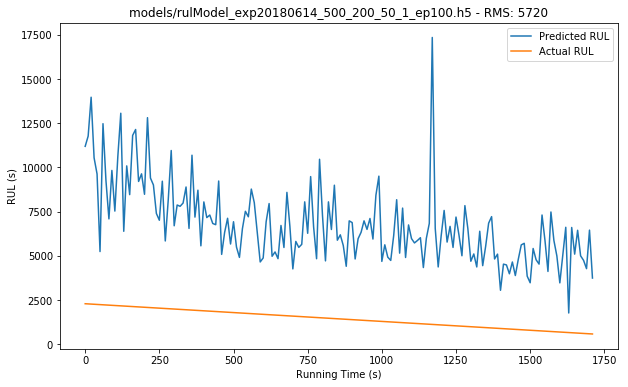

##################
# Test: 3_3
##################
352/352 [==============================] - 1s 2ms/step


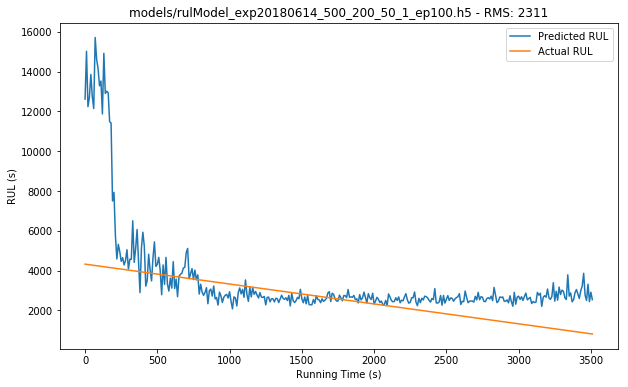

In [20]:
#%%capture outTest
layersizes = [500,200,50]
expName = 'exp20180614'
for testIndex in range(len(testspecs)):
    print('##################\n# Test: {:s}\n##################'.format(testspecs[testIndex][0]))
    actRUL =  testspecs[testIndex][1]
    testSpectro = np.concatenate((spectros_test_hor[testIndex], spectros_test_vert[testIndex]), axis=1)
    modelnames = [getModelName(layersizes, 100, expName)]
    evaluate_spectro(modelnames, testSpectro, actRUL)